In [2]:
import os
os.environ["JAX_ENABLE_X64"] = "true"
import sys
sys.path.append('..')
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ipywidgets import interact
from ml_collections import ConfigDict
from models.ETD_KT_CM_JAX_Vectorised import *
from filters import resamplers
from filters.filter import ParticleFilter
from filters.filter import ParticleFilterAll
from jax import config
jax.config.update("jax_enable_x64", True)
import numpy as np

float64


Initialisation of a twin experiment. 

In [3]:
signal_params = ConfigDict(KDV_params_2_SALT)
ensemble_params = ConfigDict(KDV_params_2_SALT)
signal_params.update(E=1,P=3,noise_magnitude = 0.01,stochastic_advection_basis='sin')
ensemble_params.update(E=128,P=3,noise_magnitude = 0.01,stochastic_advection_basis='sin')
key = jax.random.PRNGKey(0)

Now we specify the models, by calling the class.

In [4]:
signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
ensemble_model = ETD_KT_CM_JAX_Vectorised(ensemble_params)

initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
initial_ensemble = initial_condition(ensemble_model.x, ensemble_params.E, ensemble_params.initial_condition)

print(ensemble_model.params,ensemble_model.params.nt)
available_resamplers = ", ".join(resamplers.keys())
print(available_resamplers)

Advection_basis_name: constant
E: 128
Forcing_basis_name: none
P: 3
S: 0
c_0: 0
c_1: 1
c_2: 0.0
c_3: 2.0e-05
c_4: 0.0
dt: 0.001
equation_name: KdV
initial_condition: gaussian
method: Dealiased_SETDRK4
noise_magnitude: 0.01
nt: 4000
nx: 256
stochastic_advection_basis: sin
tmax: 4
xmax: 1
xmin: 0
 4000
multinomial, systematic, no_resampling, none, default


In [5]:
observation_spatial_frequency = 32
observation_locations = np.arange(0,signal_model.x.shape[0],observation_spatial_frequency)
observation_noise = 0.1
number_of_observations_time = 32 #ensemble_model.params.nt
observation_temporal_frequency = int(ensemble_model.params.nt/number_of_observations_time)
print(f"Observation temporal frequency: {observation_temporal_frequency}")
print(f"Observation spatial locations:{observation_locations}")
pf_systematic = ParticleFilterAll(
    n_particles = ensemble_params.E,
    n_steps = observation_temporal_frequency,
    n_dim = initial_signal.shape[-1],
    forward_model = ensemble_model,
    signal_model = signal_model,
    sigma = observation_noise,
    resampling="systematic",#'default',
    observation_locations = observation_locations,
)

Observation temporal frequency: 125
Observation spatial locations:[  0  32  64  96 128 160 192 224]


To run the filter with all outputs, the input arrays need to have 3 dimensions.
They are (time, n_particles, space).

In [6]:
da_steps = number_of_observations_time
print(initial_ensemble.shape, initial_signal.shape, da_steps)
initial_ensemble = initial_ensemble[None, ...] # adding the time dimension
initial_signal = initial_signal[None, ...] # adding the time dimension
key = jax.random.PRNGKey(1) # random key for JAX
final, all = pf_systematic.run(initial_ensemble, initial_signal, da_steps,key) #the final input is scan length? 

(128, 256) (1, 256) 32


In [7]:
print("final shapes:")
for i, arr in enumerate(final):
    print(f"final[{i}]:", arr.shape)

print("\nall shapes:")
for i, arr in enumerate(all):
    print(f"all[{i}]:", arr.shape)

final shapes:
final[0]: (1, 128, 256)
final[1]: (1, 1, 256)
final[2]: (2,)

all shapes:
all[0]: (32, 125, 128, 256)
all[1]: (32, 125, 1, 256)
all[2]: (32, 1, 256)


The two outputs are tuples. The first tuple has length 2 and contains the final ensemble and the final signal arrays.
The second tuple has length three and contains all outputs through time of the ensemble, signal and observation.

Put in the initial condition.

In [8]:
# particles
print(initial_ensemble.shape)
print(all[0].shape)
all_0_reshaped = jnp.reshape(all[0], (-1, all[0].shape[2], all[0].shape[3]))
print(all_0_reshaped.shape)

particles =jnp.concatenate([initial_ensemble[...], all_0_reshaped], axis=0)
print(particles.shape)

## signal 
print(all[1].shape)
all_1_reshaped = jnp.reshape(all[1], (-1, all[1].shape[2], all[1].shape[3]))
print(all_1_reshaped.shape)
print(initial_signal.shape)
signal = jnp.concatenate([initial_signal[...], all_1_reshaped], axis=0)
print(signal.shape)

## observations
print(all[2].shape)
# observations = jnp.concatenate([initial_signal[...], all[2]], axis=0)
observations = all[2][:,:, observation_locations]
print(observations.shape)


(1, 128, 256)
(32, 125, 128, 256)
(4000, 128, 256)
(4001, 128, 256)
(32, 125, 1, 256)
(4000, 1, 256)
(1, 1, 256)
(4001, 1, 256)
(32, 1, 256)
(32, 1, 8)


In [9]:
def plot(time):
    plt.plot(signal_model.x, signal[time,0,:], color='k',label='signal')
    plt.plot(signal_model.x, particles[time,:,:].T, color='b',label='particles',linewidth=0.1)
    if (time ) % observation_temporal_frequency == 0 and time !=0:
        plt.plot(signal_model.x[observation_locations], observations[int(time/observation_temporal_frequency),0,:], 'ro',label='observations')
    plt.show()

interact(plot, time=(0, ensemble_model.params.nt - 1, 1))

interactive(children=(IntSlider(value=1999, description='time', max=3999), Output()), _dom_classes=('widget-in…

<function __main__.plot(time)>

In [10]:
ensemble_params_none  = ConfigDict(KS_params_SALT)
ensemble_params_none.update(E=128,P=32,noise_magnitude = 0.01,stochastic_advection_basis='sin')
ensemble_model_none   = ETD_KT_CM_JAX_Vectorised(ensemble_params_none)
initial_signal_none   = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
initial_ensemble_none = initial_condition(ensemble_model.x, ensemble_params.E, ensemble_params.initial_condition)

pf_none = ParticleFilterAll(
    n_particles = ensemble_params.E,
    n_steps = observation_temporal_frequency,
    n_dim = initial_signal.shape[-1],
    forward_model = ensemble_model,
    signal_model = signal_model,
    sigma = observation_noise,
    resampling="no_resampling",#'default',
    observation_locations = observation_locations,
)
final_none, all_none = pf_none.run(initial_ensemble, initial_signal, da_steps,key) #the final input is scan length?
initial_ensemble_none = initial_ensemble_none[None, ...] # adding the time dimension
initial_signal_none = initial_signal_none[None, ...] # adding the time dimension
key = jax.random.PRNGKey(1) # random key for JAX

In [11]:
final_none, all_none = pf_none.run(initial_ensemble_none, initial_signal_none, da_steps,key)

In [21]:
all_none_0_reshaped = jnp.reshape(all_none[0], (-1, all_none[0].shape[2], all_none[0].shape[3]))
particles_none =jnp.concatenate([initial_ensemble_none[...], all_none_0_reshaped], axis=0)
print(all_none_0_reshaped.shape)

def plot_member_none(e):
    # Calculate observation times (y-axis) and locations (x-axis)
    obs_times = np.arange(0, particles_none.shape[0], observation_temporal_frequency )
    obs_x = signal_model.x[observation_locations]

    # For each observation time, plot scatter points at observation locations
    for t in obs_times:
        plt.scatter(observation_locations, [t]*len(observation_locations), color='red', s=10, label='Observations' if t == obs_times[0] else "")

    # Optional: only show one legend entry
    handles, labels = plt.gca().get_legend_handles_labels()
    if handles:
        plt.legend()
    plt.imshow(particles_none[:, e, :], aspect='auto', origin='lower')
    plt.title(f'Ensemble member {e} (no resampling)')
    plt.xlabel('Space')
    plt.ylabel('Time')
    plt.show()

interact(plot_member_none, e=(0, all_none_0_reshaped.shape[1] - 1))

(4000, 128, 256)


interactive(children=(IntSlider(value=63, description='e', max=127), Output()), _dom_classes=('widget-interact…

<function __main__.plot_member_none(e)>

In [13]:
def plot(time):
    plt.plot(signal_model.x, signal[time,0,:], color='k',label='signal')
    plt.plot(signal_model.x, particles[time,:,:].T, color='b',label='particles',linewidth=0.1)
    plt.plot(signal_model.x, particles_none[time,:,:].T, color='g',label='particles (no resampling)',linewidth=0.1)
    if (time ) % observation_temporal_frequency == 0 and time !=0:
        plt.plot(signal_model.x[observation_locations], observations[int(time/observation_temporal_frequency),0,:], 'ro',label='observations')
    plt.show()

interact(plot, time=(0, ensemble_model.params.nt - 1, 1))

interactive(children=(IntSlider(value=1999, description='time', max=3999), Output()), _dom_classes=('widget-in…

<function __main__.plot(time)>

In [16]:
from metrics.ensemble import rmse, crps_internal
subsample = 5# we sometimes have to subsample the data for speed issues can go as low as 5, for a 
signal_sub = signal[::subsample,:,:]
particles_sub = particles[::subsample,:,:]
particles_none_sub = particles_none[::subsample,:,:]
# Compute RMSE and CRPS for the ensemble (with resampling)
rmse_ensemble = rmse(signal_sub,particles_sub)
crps_ensemble = crps_internal(signal_sub, particles_sub)#crps(signal,particles)

# Compute RMSE and CRPS for the ensemble (no resampling)
rmse_none = rmse(signal_sub,particles_none_sub)
crps_none = crps_internal(signal_sub,particles_none_sub)
print("RMSE (systematic):", rmse_ensemble.average())
print("CRPS (systematic):", crps_ensemble)
print("RMSE (no resampling):", rmse_none)
print("CRPS (no resampling):", crps_none)


RMSE (systematic): [0.         0.00390405 0.00365463 0.00410604 0.00524862 0.00780926
 0.00960559 0.00964118 0.01161209 0.01375877 0.0134048  0.01221926
 0.01192202 0.0111035  0.01216558 0.01304513 0.01456861 0.01505992
 0.01765703 0.01715897 0.0178316  0.01893662 0.01646856 0.0142197
 0.01865666 0.01420963 0.01430095 0.01496406 0.0158591  0.01592117
 0.01606745 0.01740077 0.01861979 0.01964796 0.02081403 0.02438058
 0.02444184 0.02715289 0.02510099 0.02932793 0.02880649 0.02933424
 0.03074565 0.03312419 0.03419028 0.03495865 0.0395276  0.04159677
 0.04546433 0.04445373 0.04006196 0.04852282 0.05171442 0.04936039
 0.04958984 0.05340216 0.04396641 0.04210262 0.04954737 0.0592514
 0.05717507 0.0645249  0.06624922 0.07000156 0.07487056 0.07493865
 0.08555494 0.09183067 0.09180361 0.08710685 0.09372167 0.09688218
 0.10478529 0.10527    0.1086416  0.03984177 0.02992349 0.03626735
 0.04130654 0.04359871 0.04910226 0.06124903 0.06270437 0.06053035
 0.05337561 0.05280291 0.05432281 0.06167778 

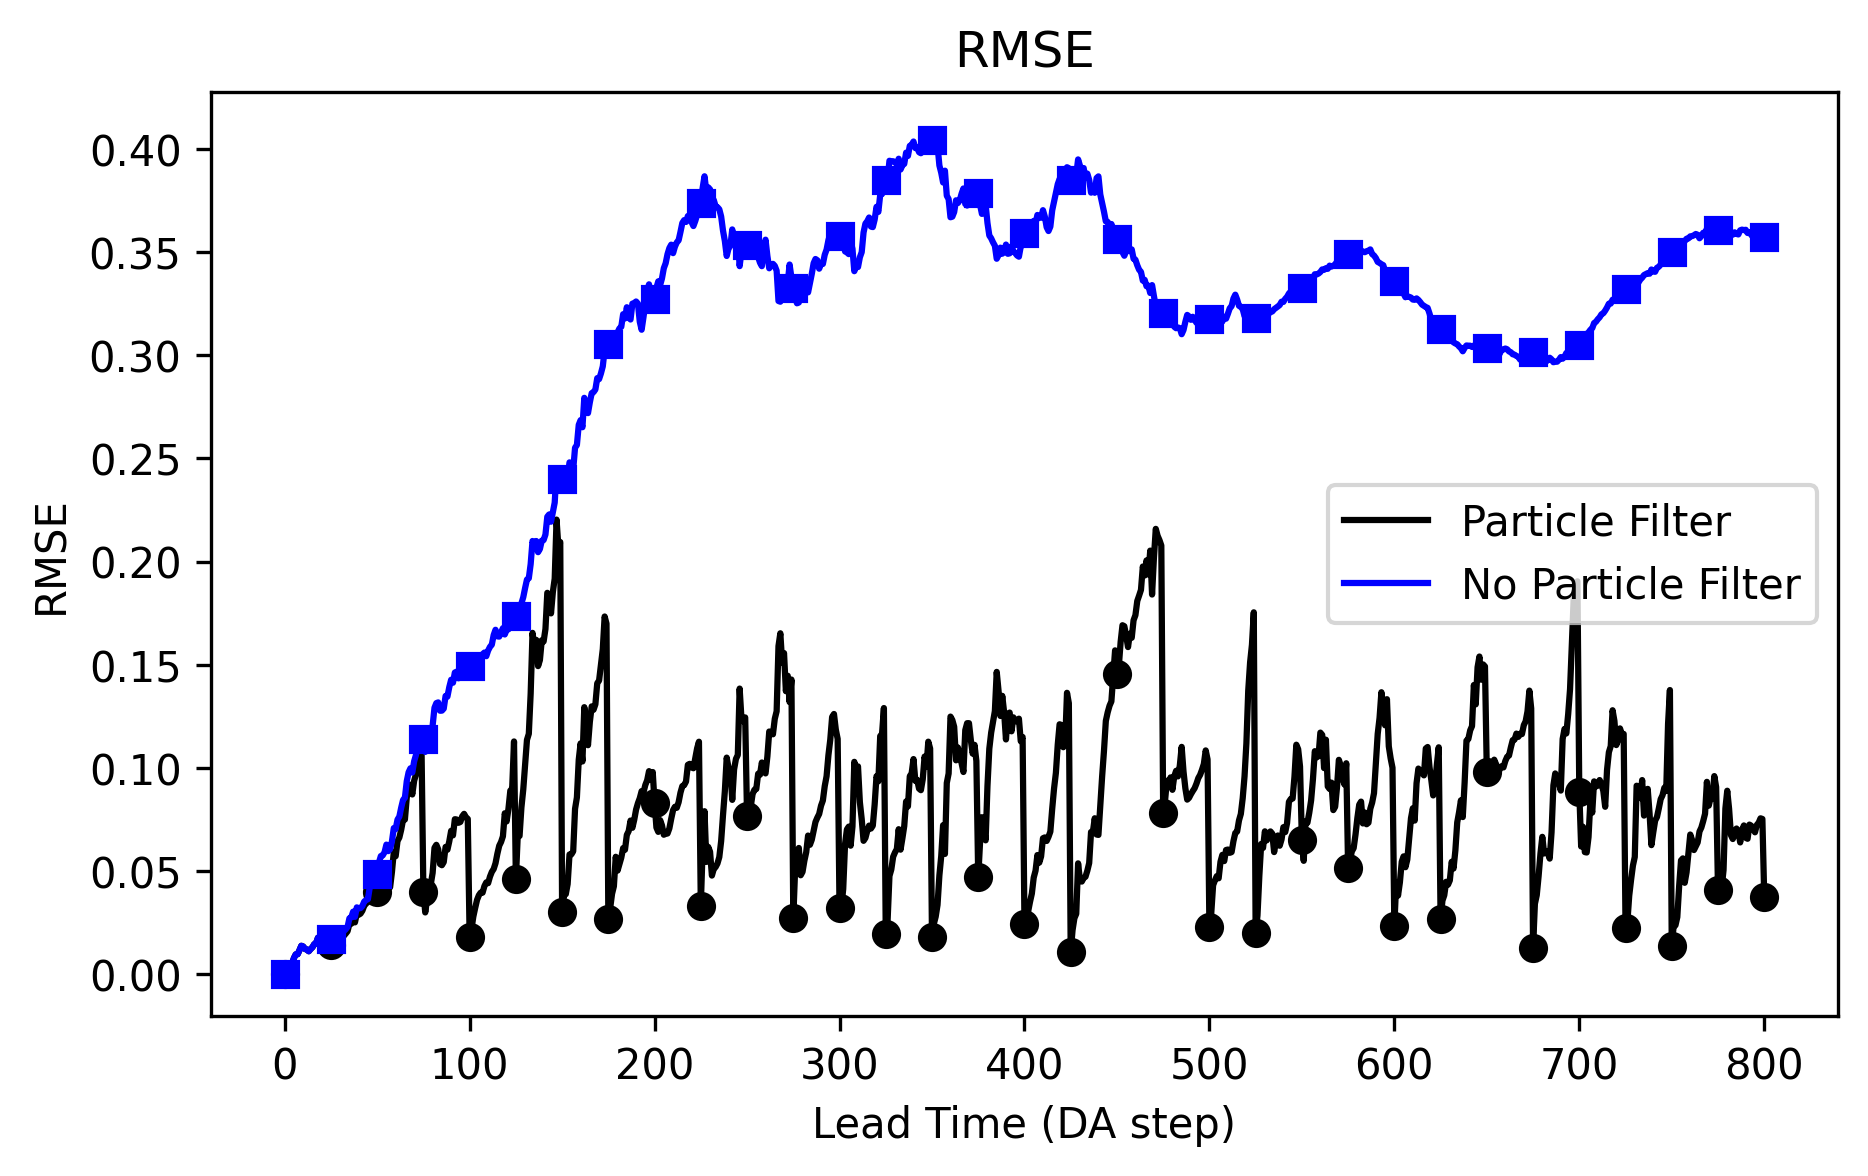

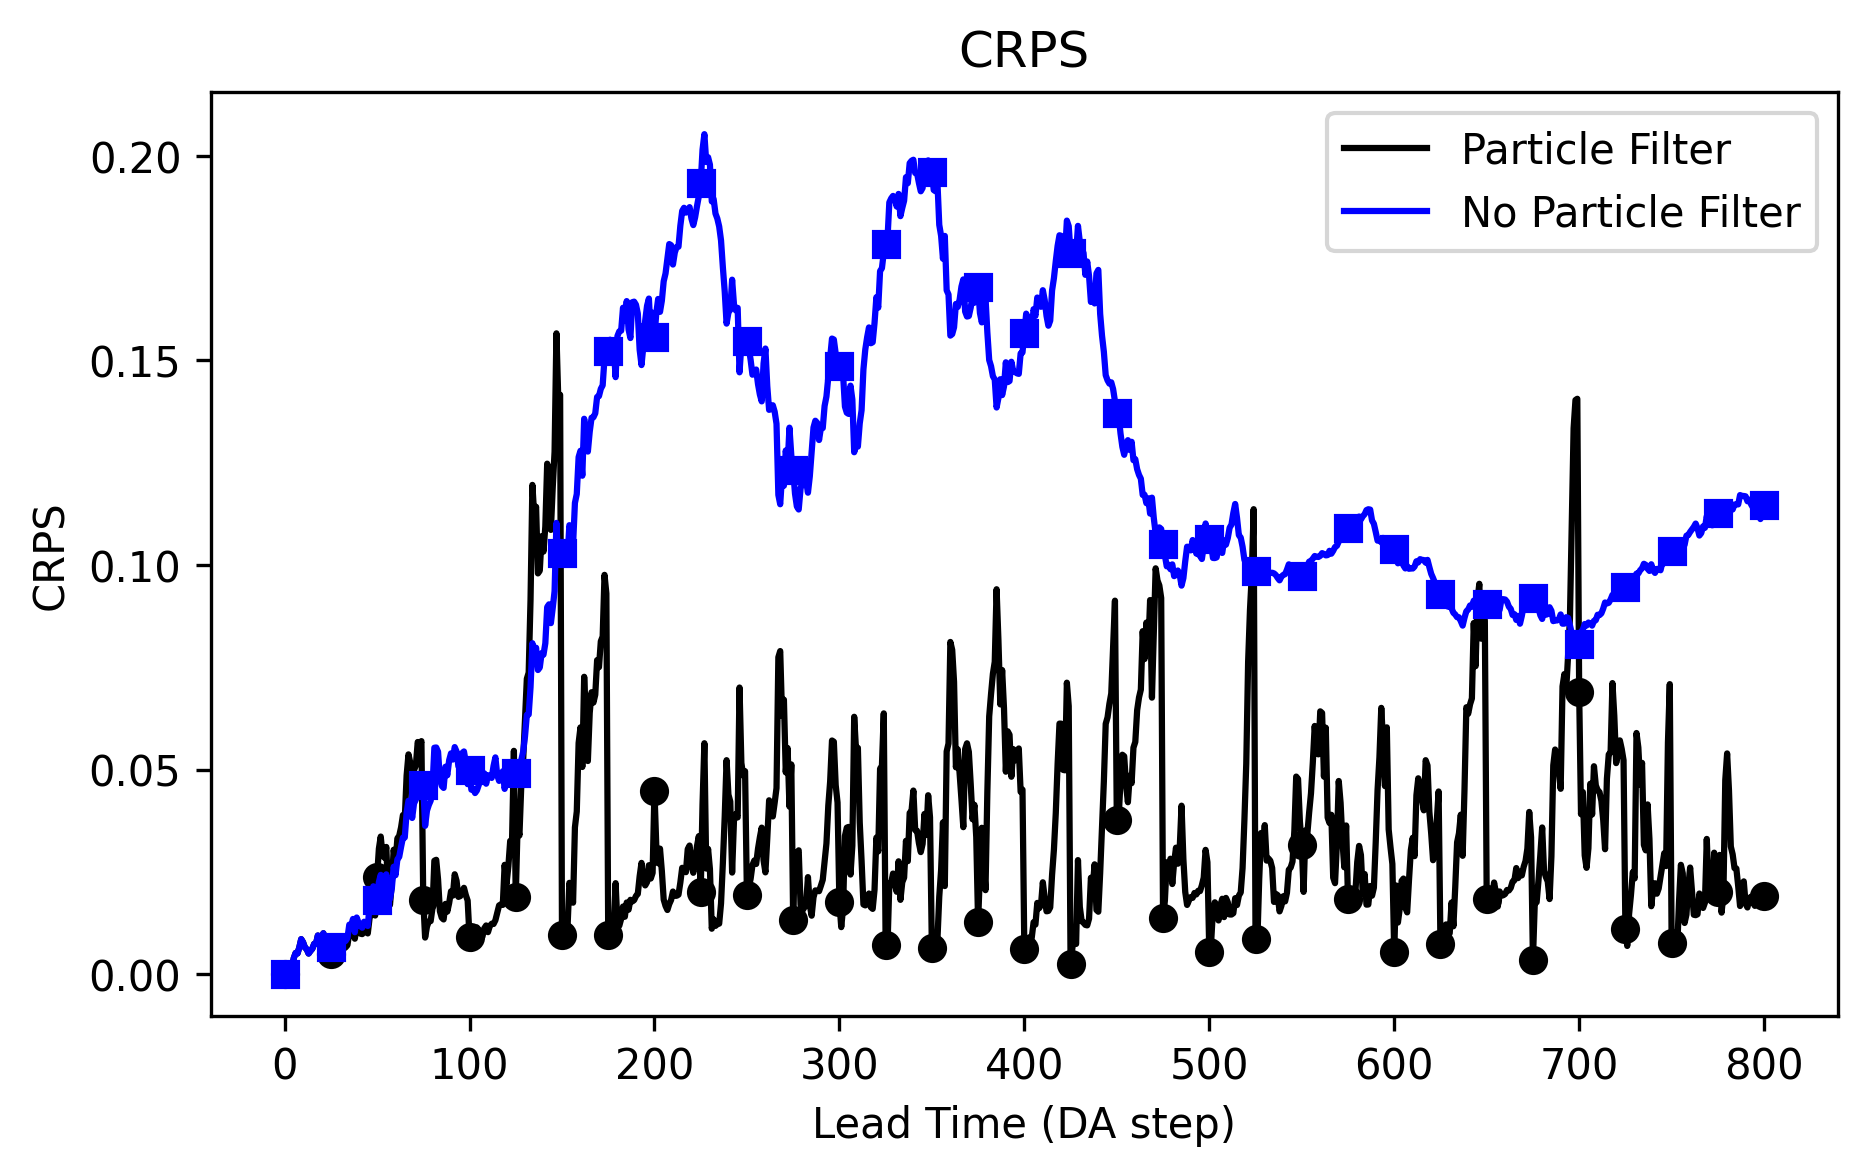

In [18]:
dpi=300
plt.figure(figsize=(7, 4), dpi=dpi)

# Plot RMSE with markers only at observation frequency
obs_idx = np.arange(0, len(rmse_ensemble), observation_temporal_frequency//subsample ) #Observation temporal frequency: 125
# should result in 32 observations for 
#obs_idx = np.arange(0, len(rmse_ensemble), observation_temporal_frequency)
plt.plot(rmse_ensemble, color='black', marker='None', label='Particle Filter')
plt.plot(obs_idx, rmse_ensemble[obs_idx], color='black', marker='o', linestyle='None')

plt.plot(rmse_none, color='blue', marker='None', label='No Particle Filter')
plt.plot(obs_idx, rmse_none[obs_idx], color='blue', marker='s', linestyle='None')
# plt.plot(rmse_ensemble, color='black', marker='o', label='Particle Filter')
# plt.plot( rmse_none, color='blue', marker='s', label='No Particle Filter')
plt.xlabel('Lead Time (DA step)')
plt.ylabel('RMSE')
plt.title('RMSE')
plt.legend()
plt.savefig('/Users/jmw/Documents/GitHub/Particle_Filter/Saving/EX3a_KdV_PF_NPF_RMSE.png', bbox_inches='tight', dpi=dpi)

plt.show()

# Plot CRPS with markers only at observation frequency
plt.figure(figsize=(7, 4), dpi=dpi)
plt.plot(crps_ensemble, color='black', marker='None', label='Particle Filter')
plt.plot(obs_idx, crps_ensemble[obs_idx], color='black', marker='o', linestyle='None')

plt.plot(crps_none, color='blue', marker='None', label='No Particle Filter')
plt.plot(obs_idx, crps_none[obs_idx], color='blue', marker='s', linestyle='None')

plt.xlabel('Lead Time (DA step)')
plt.ylabel('CRPS')
plt.title('CRPS')
plt.legend()
plt.savefig('/Users/jmw/Documents/GitHub/Particle_Filter/Saving/EX3a_KdV_PF_NPF_CRPS.png', bbox_inches='tight', dpi=dpi)

plt.show()